In [397]:
#coding: utf-8

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')

def execute(category):
    df=pd.read_csv('/Users/liyuefan/Documents/gtja/%sFI_0112.csv'%category,encoding='gbk')



    df['update_date']=pd.to_datetime(df['update_date'])
    df['close_yes']=df['close'].shift(2)

    df['ma10']=pd.rolling_mean(df['close_yes'],10)
    df['ma20']=pd.rolling_mean(df['close_yes'],20)
    df['ma30']=pd.rolling_mean(df['close_yes'],60)
    df['ma60']=pd.rolling_mean(df['close_yes'],100)
    df['ma100']=pd.rolling_mean(df['close_yes'],200)


    df['close_return_yes']=np.log(df['close_yes'])
    df['close_return_yes']=df['close_return_yes'].diff()
    df['volatility_20']=pd.rolling_std(df['close_return_yes'],20)
    df['volatility_60']=pd.rolling_std(df['close_return_yes'],60)
    df['volatility_100']=pd.rolling_std(df['close_return_yes'],100)
    df['volatility_200']=pd.rolling_std(df['close_return_yes'],200)


    def sig(x1,p):
        if p<x1:
            return -1
        elif p>x1:
            return 1
        else:
            return np.nan

#     df['stop_ma10']=map(sig,df['ma10'],df['close'])
    df['p_ma10']=map(sig,df['ma20'],df['close'])
    df['p_ma30']=map(sig,df['ma30'],df['close'])
    df['p_ma60']=map(sig,df['ma60'],df['close'])
    df['p_ma100']=map(sig,df['ma100'],df['close'])


    def dir(x):
        if x>0:
            return 1
        elif x<0:
            return -1
        else:
            return 0
    df=df.sort('update_date')


    df['p_ma10']=df['p_ma10'].fillna(method='ffill')
    df['p_ma30']=df['p_ma30'].fillna(method='ffill')
    df['p_ma60']=df['p_ma60'].fillna(method='ffill')
    df['p_ma100']=df['p_ma100'].fillna(method='ffill')

    df=df.dropna(axis=0)

    pos_mat=df.loc[:,['p_ma10','p_ma30','p_ma60','p_ma100','volatility_20','volatility_60','volatility_100','volatility_200']]
    pos_mat=pos_mat.as_matrix()

    N=pos_mat.shape[0]
    p=np.zeros(N)
    temp_tag=0
    for i in range(N):
        if np.isnan(pos_mat[i,3])==True:
            p[i]=0
        else:
            if pos_mat[i,0]>0:
                temp_tag=1
                dis_20=pos_mat[i,4]/np.mean(pos_mat[:i,4])
                dis_60=pos_mat[i,5]/np.mean(pos_mat[:i,5])
                dis_100=pos_mat[i,6]/np.mean(pos_mat[:i,6])
                dis_200=pos_mat[i,7]/np.mean(pos_mat[:i,7])
#                 p[i]=0.4/dis_20
                p[i]=0.4
                if pos_mat[i,3]>0:
#                     p[i]=(0.4/dis_20+0.3/dis_60+0.2/dis_100+0.1/dis_200)
                    p[i]=(0.4+0.3+0.2+0.1)
                elif pos_mat[i,2]>0:
#                     p[i]=(0.4/dis_20+0.3/dis_60+0.2/dis_100)
                    p[i]=(0.4+0.3+0.2)
                elif pos_mat[i,1]>0:
#                     p[i]=(0.4/dis_20+0.3/dis_60)
                    p[i]=(0.4+0.3)

            elif pos_mat[i,0]<0:
                temp_tag=-1
                dis_20=pos_mat[i,4]/np.mean(pos_mat[:i,4])
                dis_60=pos_mat[i,5]/np.mean(pos_mat[:i,5])
                dis_100=pos_mat[i,6]/np.mean(pos_mat[:i,6])
                dis_200=pos_mat[i,7]/np.mean(pos_mat[:i,7])
#                 p[i]=-0.4/dis_20
                p[i]=-0.4
                if pos_mat[i,3]<0:
#                     p[i]=(-0.4/dis_20-0.3/dis_60-0.2/dis_100-0.1/dis_200)
                    p[i]=(-0.4-0.3-0.2-0.1)
                elif pos_mat[i,2]<0:
#                     p[i]=(-0.4/dis_20-0.3/dis_60-0.2/dis_200)
                    p[i]=(-0.4-0.3-0.2)

                elif pos_mat[i,1]<0:
#                     p[i]=(-0.4/dis_20-0.3/dis_60)
                    p[i]=(-0.4-0.3)

#             elif temp_tag>0 and pos_mat[i,8]==-1:
#                 temp_tag=0
#                 print 'stop'
#                 p[i]=0
#             elif temp_tag<0 and pos_mat[i,8]==1:
#                 temp_tag=0
#                 print 'stop'
#                 p[i]=0
            else:
                p[i]=np.nan



    df['position']=p
    df['position']=df['position'].fillna(method='ffill')

    df['close_return']=np.log(df['close'])
    df['close_return']=df['close_return'].diff()

    df['position']=df['position'].shift(2)



    df['daily_return']=df['position']*df['close_return']
    
    
    close_return=np.array(df['daily_return'])
    position=np.array(df['position'])
    for i in range(1,len(position)):
        if position[i]!=position[i-1]:
            close_return[i-1]=close_return[i-1]-1./10000
            close_return[i]=close_return[i]-1./10000
        else:
            pass
    df['daily_return']=close_return


    

    df['cum_return']=df['daily_return'].cumsum()

    df.index=[df['update_date']]
    return df

In [398]:
def portfolio(comp1,comp2):
    if type(comp1)==str and type(comp2)==str:
        comp1=execute(comp1)
        comp2=execute(comp2)
    else:
        comp1=comp1
        comp2=comp2
    comp1=comp1.rename(columns={'daily_return':'daily_return_1','close_return':'close_return_1'})
    comp2=comp2.rename(columns={'daily_return':'daily_return_2','close_return':'close_return_2'})
    t=pd.merge(comp1,comp2,on='update_date',how='inner')

    tt=t.loc[:,['update_date','daily_return_1','daily_return_2','close_return_1','close_return_2']]

    tt['portfolio_return']=0.5*tt['daily_return_1']+0.5*tt['daily_return_2']
    tt['close_return']=0.5*tt['close_return_1']+0.5*tt['close_return_2']

    tt['port_cum_return']=tt['portfolio_return'].cumsum()
    tt['port_cummax']=tt['port_cum_return'].cummax()
    tt['port_drawdown']=tt['port_cum_return']-tt['port_cummax']
    tt['update_date']=pd.to_datetime(tt['update_date'])
    return tt

In [399]:
def port_port(port1,port2):
    port1=port1.drop(['daily_return_1','daily_return_2','close_return_1','close_return_2'],axis=1)
    port2=port2.drop(['daily_return_1','daily_return_2','close_return_1','close_return_2'],axis=1)
    port1=port1.rename(columns={'portfolio_return':'daily_return_1','close_return':'close_return_1'})
    port2=port2.rename(columns={'portfolio_return':'daily_return_2','close_return':'close_return_2'})
    
    t=pd.merge(port1,port2,on='update_date',how='inner')

    tt=t.loc[:,['update_date','daily_return_1','daily_return_2','close_return_1','close_return_2']]
    
    tt['portfolio_return']=0.5*tt['daily_return_1']+0.5*tt['daily_return_2']
    tt['close_return']=0.5*tt['close_return_1']+tt['close_return_2']
    
    tt['port_cum_return']=tt['portfolio_return'].cumsum()
    tt['port_cummax']=tt['port_cum_return'].cummax()
    tt['port_drawdown']=tt['port_cum_return']-tt['port_cummax']
    return tt

In [400]:
def comp_portfolio(asset_pool):
    import itertools
    import scipy as sp
    import scipy.stats as stats
    all_assets=pd.DataFrame(columns=['update_date'])
    for a in asset_pool:
        tmp=execute(a)
#         tmp=tmp.loc[:,['update_date','daily_return']]
        tmp=tmp.loc[:,['update_date','close_return']] 
#         tmp=tmp.rename(columns={'daily_return':'%s'%a})
        tmp=tmp.rename(columns={'close_return':'%s'%a})
        all_assets=pd.merge(all_assets,tmp,on='update_date',how='outer')
    all_assets['update_date']=pd.to_datetime(all_assets['update_date'])
    all_assets['year']=all_assets['update_date'].apply(lambda x: x.year)
    selected_port_dict={}
    for year in pd.unique(all_assets['year']):
        tmp=all_assets[all_assets['year']==year]
        tmp=tmp.dropna(how='all',axis=1)
        col_list=[col for col in tmp.columns if col!='update_date' and col!='year']
        corr_dict={}
        for item in itertools.product(col_list,col_list):
            if item[0]!=item[1]:
                cor_mat=tmp.loc[:,item]
                cor_mat=cor_mat.dropna(axis=0)
                cor_mat=cor_mat.as_matrix()
#                 corr=sp.corrcoef(cor_mat.T)
                corr,p=stats.pearsonr(cor_mat[:,0],cor_mat[:,1])
#                 corr=corr[0,1]
                if p>0.01:
                    corr_dict[item]=np.abs(corr)
                else:
                    corr_dict[item]=np.nan
            else:
                pass
        corr_dict_items=filter(lambda x:np.isnan(x[1])==False,corr_dict.items())
        if len(corr_dict_items)>=4:
            selected_port=[item for item in sorted(corr_dict_items, key=lambda d:d[1],reverse=False)][0:3]
            selected_port_1=selected_port[0]
            selected_list=[x for x in selected_port_1[0]]
            for i in range(len(selected_port)):
                tmp_1=selected_port[i][0]
                if tmp_1[0] not in selected_list or tmp_1[1] not in selected_list:
                    selected_port_2=selected_port[i]
                else:
                    pass
            selected_port_dict[year+1]=[selected_port_1,selected_port_2]
        
            print year+1, selected_port_1, '%.3f'%selected_port_dict[year+1][0][1]
            print year+1, selected_port_2, '%.3f'%selected_port_dict[year+1][1][1]
        #如果无法通过相关性检验，则选择波动性最低的几个品种
        else:
            tmp_=tmp.drop(['update_date','year'],axis=1)
            
            std_list=np.std(tmp_)
            std_list=std_list.to_dict()
            std_list=filter(lambda x:np.isnan(x[1])==False,std_list.items())
            if len(std_list)>=4:
                selected_port=[item for item in sorted(std_list,key=lambda d:d[1],reverse=False)][0:4]
                selected_port_1=((selected_port[0][0],selected_port[1][0]),0)
                selected_port_2=((selected_port[2][0],selected_port[3][0]),0)
                selected_port_dict[year+1]=[selected_port_1,selected_port_2]
                print 'std min: ',year+1, selected_port_1#, '%.3f'%selected_port_dict[year+1][0][1]
                print 'std min: ',year+1, selected_port_2#, '%.3f'%selected_port_dict[year+1][1][1]
            #如果还不行，那就直接按照过去一年的累积收益率高低进行排序，选择去年收益率最低的做一个反转策略
            else:
            
            
            
                mean_list=np.abs(np.mean(tmp_))
                mean_list=mean_list.to_dict()
                mean_list=filter(lambda x:np.isnan(x[1])==False,mean_list.items())


                if len(mean_list)>=4:
                    selected_port=[item for item in sorted(mean_list,key=lambda d:d[1],reverse=False)][0:4]
                    selected_port_1=((selected_port[0][0],selected_port[1][0]),0)
                    selected_port_2=((selected_port[2][0],selected_port[3][0]),0)
                    selected_port_dict[year+1]=[selected_port_1,selected_port_2]
                    print 'mean reverse: ',year+1, selected_port_1#, '%.3f'%selected_port_dict[year+1][0][1]
                    print 'mean reverse: ',year+1, selected_port_2#, '%.3f'%selected_port_dict[year+1][1][1]
                #如果这样都不行的话...
                else:
                    pass
                    print u'另请高明：',year+1
                    

                
            
    return selected_port_dict
    
                

In [401]:
asset_pool=['CU','ZN','PB','AL','NI','I','JM','J','WH','ZC','Y','TA','SR','RU','RM','P','M','C']

In [402]:
a=comp_portfolio(asset_pool)

2009 (('SR', 'CU'), 0.0020904694451032574) 0.002
2009 (('SR', 'RU'), 0.01219119786240448) 0.012
std min:  2010 (('C', 'AL'), 0)
std min:  2010 (('SR', 'TA'), 0)
std min:  2011 (('C', 'M'), 0)
std min:  2011 (('Y', 'AL'), 0)
std min:  2012 (('C', 'AL'), 0)
std min:  2012 (('M', 'SR'), 0)
std min:  2013 (('C', 'AL'), 0)
std min:  2013 (('PB', 'ZN'), 0)
2014 (('CU', 'WH'), 0.019663229192058974) 0.020
2014 (('ZN', 'WH'), 0.02279566878646978) 0.023
2015 (('ZN', 'C'), 0.0036662228937167688) 0.004
2015 (('TA', 'C'), 0.0043726208227771917) 0.004
2016 (('I', 'C'), 0.059758390044729486) 0.060
2016 (('C', 'ZC'), 0.074407407535018677) 0.074
2017 (('PB', 'WH'), 0.0015806961621015771) 0.002
2017 (('WH', 'I'), 0.0032679604026980653) 0.003
2018 (('JM', 'P'), 0.0024790335261145489) 0.002
2018 (('P', 'J'), 0.0024790335261145489) 0.002


In [403]:
mixed_port=pd.DataFrame()
for item in a.items():
    print item[0]

    
#####如果取前两对############
    print item
    tmp_1=portfolio(item[1][0][0][0],item[1][0][0][1])
    tmp_1['update_date']=pd.to_datetime(tmp_1['update_date'])
    tmp_1=tmp_1[tmp_1['update_date'].apply(lambda x:x.year)==item[0]]
    tmp_2=portfolio(item[1][1][0][0],item[1][1][0][1])
    tmp_2['update_date']=pd.to_datetime(tmp_2['update_date'])
    tmp_2=tmp_2[tmp_2['update_date'].apply(lambda x:x.year)==item[0]]
    tmp=port_port(tmp_1,tmp_2)

#####如果只取一对###########
#     tmp=portfolio(item[1][0][0][0],item[1][0][0][1])
#     tmp['update_date']=pd.to_datetime(tmp['update_date'])
#     tmp=tmp[tmp['update_date'].apply(lambda x:x.year)==item[0]]
##########################
    
    if len(tmp)>0:
        tmp['update_date']=pd.to_datetime(tmp['update_date'])
        tmp=tmp[tmp['update_date'].apply(lambda x:x.year)==item[0]]
        tmp=tmp.loc[:,['update_date','portfolio_return','close_return']]
        mixed_port=mixed_port.append(tmp)
    else:
        print 'no data!'
        pass
    

2016
(2016, [(('I', 'C'), 0.059758390044729486), (('C', 'ZC'), 0.074407407535018677)])
2017
(2017, [(('PB', 'WH'), 0.0015806961621015771), (('WH', 'I'), 0.0032679604026980653)])
2018
(2018, [(('JM', 'P'), 0.0024790335261145489), (('P', 'J'), 0.0024790335261145489)])
no data!
2009
(2009, [(('SR', 'CU'), 0.0020904694451032574), (('SR', 'RU'), 0.01219119786240448)])
2010
(2010, [(('C', 'AL'), 0), (('SR', 'TA'), 0)])
2011
(2011, [(('C', 'M'), 0), (('Y', 'AL'), 0)])
2012
(2012, [(('C', 'AL'), 0), (('M', 'SR'), 0)])
2013
(2013, [(('C', 'AL'), 0), (('PB', 'ZN'), 0)])
2014
(2014, [(('CU', 'WH'), 0.019663229192058974), (('ZN', 'WH'), 0.02279566878646978)])
2015
(2015, [(('ZN', 'C'), 0.0036662228937167688), (('TA', 'C'), 0.0043726208227771917)])


In [404]:
mixed_port=mixed_port.sort('update_date')
mixed_port['cum_return']=mixed_port['portfolio_return'].cumsum()
mixed_port['benchmark']=mixed_port['close_return'].cumsum()
mixed_port['cum_max']=mixed_port['cum_return'].cummax()
mixed_port['drawdown']=mixed_port['cum_return']-mixed_port['cum_max']

In [405]:
mixed_port

,update_date,portfolio_return,close_return,cum_return,benchmark,cum_max,drawdown
0,2009-01-05,-0.014347,0.045679,-0.014347,0.045679,-0.014347,0.000000
1,2009-01-06,-0.014030,0.051900,-0.028376,0.097579,-0.014347,-0.014030
2,2009-01-07,0.007808,-0.003001,-0.020568,0.094578,-0.014347,-0.006221
3,2009-01-08,-0.000435,-0.008970,-0.021003,0.085608,-0.014347,-0.006656
4,2009-01-09,0.010659,0.019087,-0.010344,0.104695,-0.010344,0.000000
5,2009-01-12,-0.017987,0.037029,-0.028331,0.141724,-0.010344,-0.017987
6,2009-01-13,-0.001853,-0.027005,-0.030184,0.114719,-0.010344,-0.019840
7,2009-01-14,0.018764,0.059912,-0.011419,0.174631,-0.010344,-0.001075
8,2009-01-15,-0.004275,-0.026822,-0.015694,0.147810,-0.010344,-0.005350
9,2009-01-16,0.008180,0.023121,-0.007514,0.170931,-0.007514,0.000000


In [406]:
np.min(mixed_port['drawdown']/(1+mixed_port['cum_max']))

-0.11920274119653938

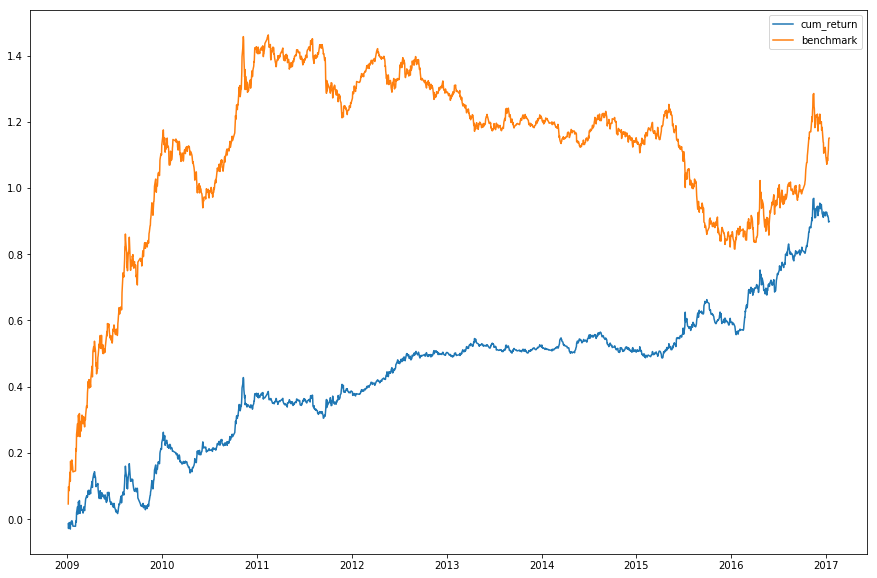

In [407]:
plt.figure(figsize=(15,10))
plt.plot(mixed_port['update_date'],mixed_port['cum_return'])
plt.plot(mixed_port['update_date'],mixed_port['benchmark'],label='benchmark')
plt.legend()

In [408]:
mixed_port['year']=mixed_port['update_date'].apply(lambda x: x.year)
each_year_return=mixed_port.groupby(['year']).portfolio_return.sum()

In [409]:
each_year_return

year
2009    0.230824
2010    0.140141
2011    0.015932
2012    0.116151
2013    0.017122
2014   -0.016165
2015    0.089666
2016    0.333999
2017   -0.029099
Name: portfolio_return, dtype: float64

In [410]:
(np.mean(mixed_port['portfolio_return'])*252)/(np.std(mixed_port['portfolio_return'])*np.sqrt(252))

1.03965626273878

In [411]:
np.mean(mixed_port['portfolio_return'])*252

0.11600407678336572

In [412]:
ying_strategy=pd.read_csv('/Users/liyuefan/Downloads/ying_strategy.csv')

In [413]:
ying_strategy=ying_strategy[['update_date','pl']]

In [414]:
ying_strategy['update_date']=pd.to_datetime(ying_strategy['update_date'])

In [415]:
t1=mixed_port[['update_date','portfolio_return']]
t2=ying_strategy[['update_date','pl']]
t3=pd.merge(t1,t2,on=['update_date'],how='inner')

In [416]:
r1=np.array(t3['portfolio_return'])
r2=np.array(t3['pl'])

In [417]:
from scipy.stats import pearsonr

In [418]:
corr,p=pearsonr(r1,r2)

In [419]:
t3['cum_1']=t3['portfolio_return'].cumsum()
t3['cum_2']=t3['pl'].cumsum()

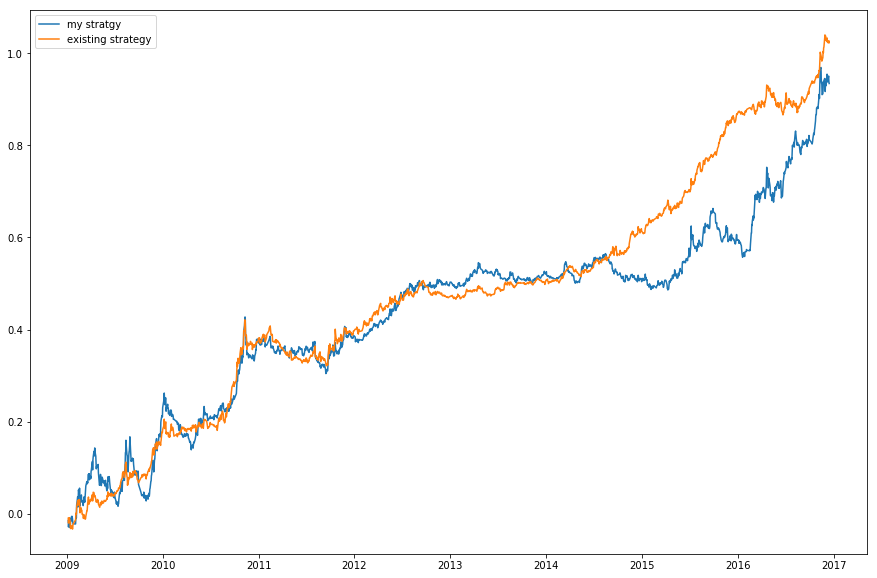

In [420]:
plt.figure(figsize=(15,10))
plt.plot(t3['update_date'],t3['cum_1'],label='my stratgy')
plt.plot(t3['update_date'],t3['cum_2'],label='existing strategy')
plt.legend()

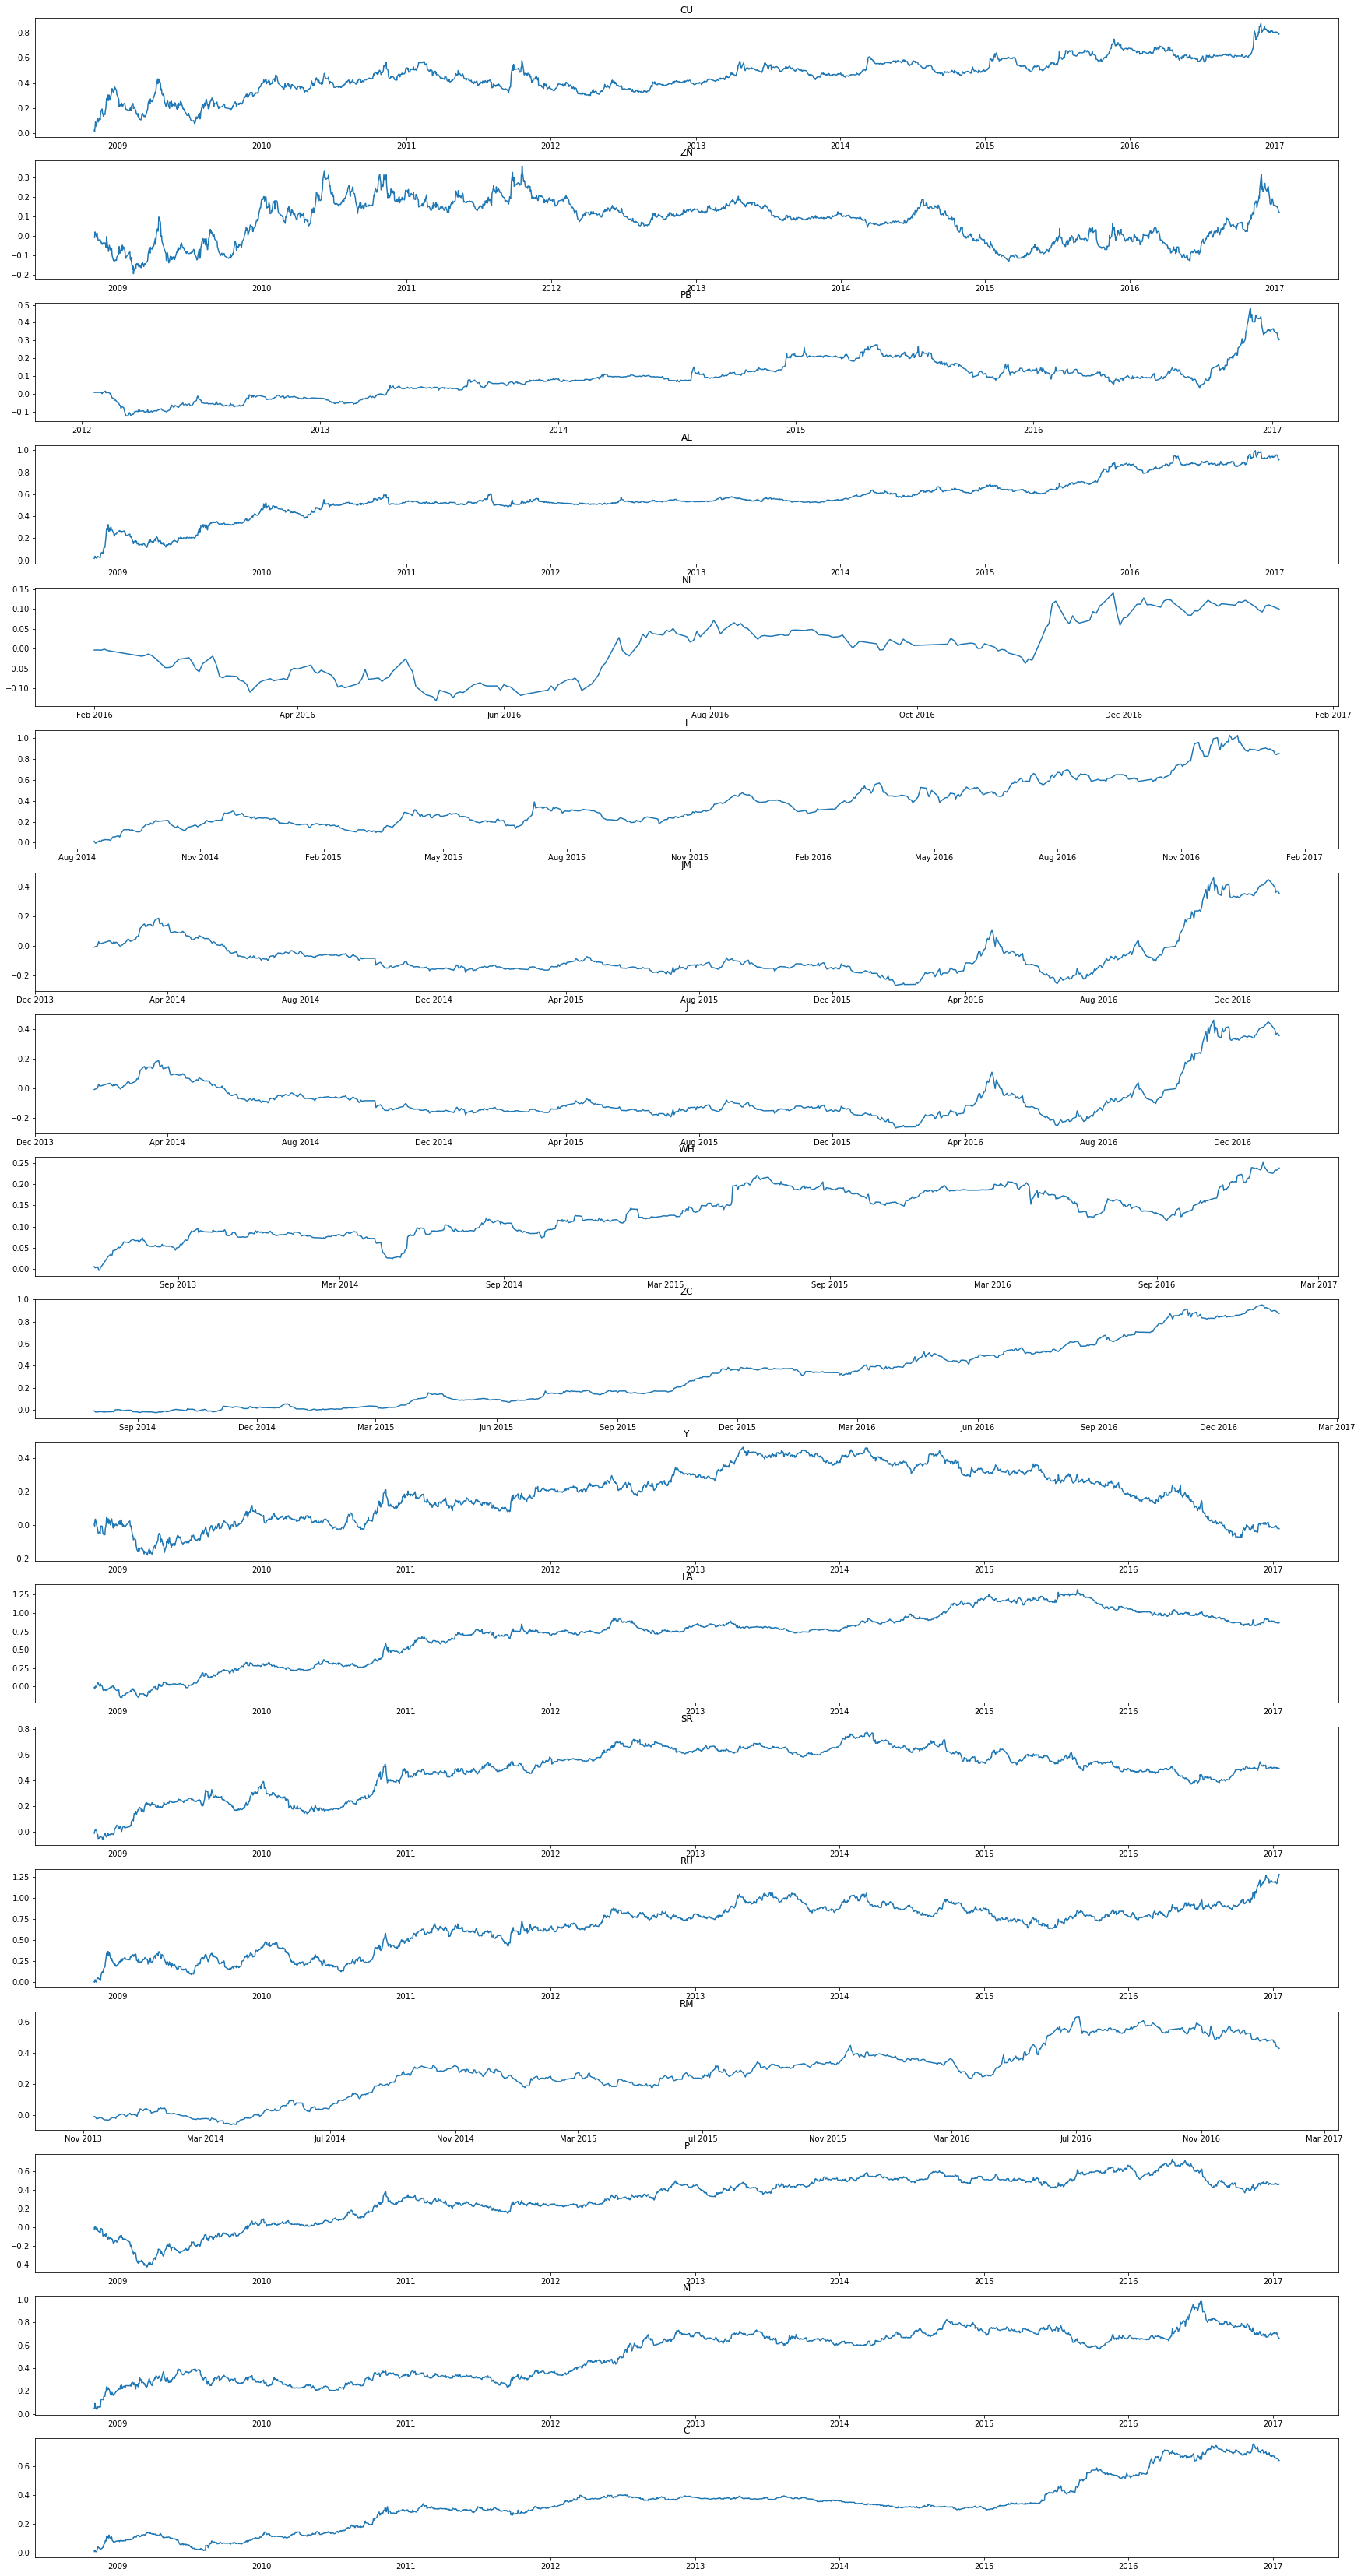

In [421]:
plt.figure(figsize=(30,60))
N=len(asset_pool)
i=1
for a in asset_pool:
    plt.subplot(N,1,i)
    tmp=execute(a)
    plt.plot(tmp['cum_return'])
    plt.title(a)
    i+=1